In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 8.4MB/s 


In [ ]:
#Importamos las librerías de costumbre
import numpy as np
import pandas as pd
#Instalamos la librería que nos va a permitir bajar de drive
!pip install gdown
import gdown
#Colocamos la URL del archivo
url = 'https://drive.google.com/file/d/1ZJnnNSFjqiwbeyZdEB7j39oqQAtH15wB/view?usp=sharing'
#Colocamos el nombre al archivo donde la información será guardada
Nombre = 'Vehiculos.zip'
#Lo descargamos
gdown.download(url,Nombre,quiet=False)

/usr/local/lib/python3.6/dist-packages/gdown/parse_url.py:31: UserWarning: You specified Google Drive Link but it is not the correct link to download the file. Maybe you should try: https://drive.google.com/uc?id=1ZJnnNSFjqiwbeyZdEB7j39oqQAtH15wB
  .format(url='https://drive.google.com/uc?id={}'.format(file_id))
Downloading...
From: https://drive.google.com/file/d/1ZJnnNSFjqiwbeyZdEB7j39oqQAtH15wB/view?usp=sharing
To: /content/Vehiculos.zip
69.7kB [00:00, 2.81MB/s]


'Vehiculos.zip'

In [ ]:
#Importación de librerías necesarias

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from pyunpack import Archive
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import json

In [ ]:
#Descompresión de las imágenes

os.mkdir('dataset')
Archive('/content/drive/MyDrive/tesis/Vehiculos.zip').extractall('dataset/')

In [ ]:
#Se cargan los conjustos de imágenes y se reescalan

BATCH_SIZE = 20
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split = 0.3)

train_generator = train_datagen.flow_from_directory(
    directory='dataset/Vehiculos/Train',
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory='dataset/Vehiculos/Validation', # same directory as training data
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    subset='validation') # set as validation data

Found 5128 files belonging to 2 classes.
Found 1465 files belonging to 2 classes.
Found 732 files belonging to 2 classes.


In [ ]:
#Cambiar la escala de los valores de píxeles de las imágenes 

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
# Creación sel modelo base a partir del modelo previamente entrenado MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#Congelar la base convolucional
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#Agregar un encabezado de clasificación

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1,activation = "sigmoid",kernel_initializer='random_normal',bias_initializer='zeros')

In [ ]:
#Usar aumento de datos

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
def write_json(dataz, filename): 
	with open(filename,'w') as f: 
	    json.dump(dataz, f, indent=4) 

data = []

with open('history.json', 'w') as file:
    json.dump(data, file, indent=4)

In [ ]:
#Compilar el modelo y entrenarlo

os.mkdir('modelos')
base_learning_rate = 0.005
history = []
contador = 0
for i in range(1,101):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    mcp_save = ModelCheckpoint('/content/modelos/transfer_learning_V_'+str(i)+'.hdf5', save_best_only=True, monitor='val_loss', mode='min',save_weights_only=False)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    history.append(model.fit(train_dataset,epochs=100,callbacks=[mcp_save],validation_data=validation_dataset))

    with open('history.json') as json_file: 
	    datay = json.load(json_file) 
     
	    temp = datay

	    y = { 'accuracy': history[contador].history['accuracy'],
            'loss': history[contador].history['val_loss']
      }        		     

	    temp.append(y) 
    write_json(datay, 'history.json')  
 
    contador = contador + 1
    del model

Epoch 1/100
342/342 [==============================] - 21s 34ms/step - loss: 0.1648 - accuracy: 0.9373 - val_loss: 0.1723 - val_accuracy: 0.9386
Epoch 2/100
342/342 [==============================] - 10s 30ms/step - loss: 0.0666 - accuracy: 0.9738 - val_loss: 0.1458 - val_accuracy: 0.9468
Epoch 3/100
342/342 [==============================] - 11s 32ms/step - loss: 0.0588 - accuracy: 0.9797 - val_loss: 0.1236 - val_accuracy: 0.9570
Epoch 4/100
342/342 [==============================] - 11s 31ms/step - loss: 0.0734 - accuracy: 0.9728 - val_loss: 0.1486 - val_accuracy: 0.9529
Epoch 5/100
342/342 [==============================] - 11s 31ms/step - loss: 0.0570 - accuracy: 0.9797 - val_loss: 0.1074 - val_accuracy: 0.9625
Epoch 6/100
342/342 [==============================] - 11s 31ms/step - loss: 0.0615 - accuracy: 0.9806 - val_loss: 0.1160 - val_accuracy: 0.9652
Epoch 7/100
342/342 [==============================] - 11s 31ms/step - loss: 0.0531 - accuracy: 0.9821 - val_loss: 0.1450 - val_ac

In [ ]:
    with open('history.json') as json_file: 
	    datay = json.load(json_file) 
     
	    temp = datay

	    y = { 'accuracy': history[0].history['accuracy'],
            'loss': history[0].history['val_loss']
      }        		     

	    temp.append(y) 
    write_json(datay, 'history.json')  

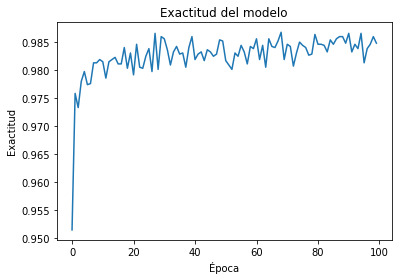

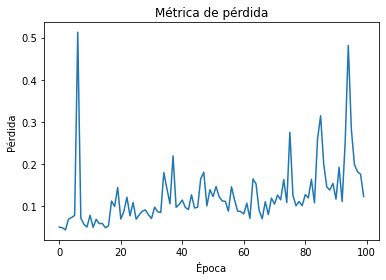

In [ ]:
#Visualización de los resultados en gráficas

for i in range(len(history)):
  plt.plot(history[i].history['accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.show()
# "Loss"
for i in range(len(history)):
  plt.plot(history[i].history['val_loss'])
plt.title('Métrica de pérdida')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

In [ ]:
#calculo del porcentajes de validación 

best_val_history = []
for i in range(1,101):
    model = load_model('modelos/transfer_learning_'+str(i)+'.hdf5')
    best_val_history.append(model.evaluate(validation_dataset))
    del model

46/46 [==============================] - 23s 489ms/step - loss: 0.0499 - accuracy: 0.9775


OSError: ignored

In [ ]:
#Calculo de promedios de validación y pérdida 

prom_loss = 0.0;
prom_acc = 0.0;
for i in range(len(best_val_history)):
    prom_loss = prom_loss + best_val_history[i][0]
    prom_acc = prom_acc + best_val_history[i][1]

prom_loss = prom_loss / len(best_val_history)
prom_acc = prom_acc / len(best_val_history)

print(prom_loss)
print(prom_acc)

0.05113038793206215
0.9777474284172059


In [ ]:
import shutil
shutil.make_archive("modelos_vehiculo", 'zip', "modelos")

'/content/TipoVehiculo.zip'